In [1]:
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from node2vec import Node2Vec
import os
import pickle

pd.set_option('display.max_columns', None)


# Load the dataset from backoffice
df_pueblos = pd.read_csv("../../data/end_product_data/pueblos_recommender.csv")

pueblos_cmun = df_pueblos['cmun'].tolist()

# Load the dataset from user chosen villages
user_files = os.listdir("../../data/user_output/")

user_choices = []

# Get all files from the user_output directory

# Read each file into a DataFrame and add to the list
for file in user_files:
    file_path = os.path.join("../../data/user_output/", file)
    user_df = pd.read_csv(file_path)
    user_choices.append(user_df)

# user choices of first user
user_choices_cmun = user_choices[0].cmun.tolist()
# display(pueblos_cmun)
# display(user_choices_cmun)
df_pueblos.shape

/Users/kaygensmann/www/python/bootcamp/ml-pueblos/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(6824, 68)

In [2]:
df_pueblos_enc = df_pueblos.filter(regex=r"^enc_", axis=1)
# Select only numerical features with more than 2 unique values (non-binary features)
pueblos_numerical_features = df_pueblos_enc.loc[:, (df_pueblos_enc.nunique() > 2)]

# Process user choices: filter for encoded features and remove binary columns
processed_user_choices = []
for df in user_choices:
    df_filtered = df.filter(regex=r"^enc_", axis=1)
    df_non_binary = df_filtered.loc[:, ~(df_filtered.isin([0.0, 1.0]).all())]
    processed_user_choices.append(df_non_binary)

display(processed_user_choices[0])
display(pueblos_numerical_features)


,enc_scaled__score_age,enc_scaled__score_transport,enc_scaled__score_area_school,enc_scaled__score_school_distance,enc_scaled__score_area_hospital,enc_scaled__score_hospital_distance,enc_scaled__score_area_economy,enc_scaled__score_economy,enc_scaled__score_connectivity,enc_scaled__female,enc_scaled__count_of_stations,enc_scaled__number_of_houses,enc_scaled__total_population,enc_scaled__latitude,enc_scaled__longitude
0,1.009797,-0.194602,-0.265322,-0.265322,-0.892572,-0.892572,1.163513,1.163513,0.941276,1.764566,-0.321851,1.619750,1.800663,-0.999609,0.397004
1,0.614219,-0.909432,0.719746,0.719746,2.591711,2.591711,-0.400296,-0.400296,1.107346,-0.480153,-0.321851,-0.622806,-0.497290,-1.248641,0.969978
2,1.390994,-1.159255,0.719746,0.719746,1.043140,1.043140,0.120974,0.120974,1.135024,0.229121,1.568262,-0.246047,0.170848,0.678372,2.329812
3,1.091498,-0.567652,0.719746,0.719746,1.043140,1.043140,0.120974,0.120974,0.980351,0.334959,-0.321851,0.142711,0.336112,1.303048,0.157671
4,0.436124,-0.803842,0.719746,0.719746,2.591711,2.591711,-0.400296,-0.400296,1.068271,-0.484892,-0.321851,-0.525616,-0.502012,1.006129,0.147756


,enc_scaled__score_age,enc_scaled__score_transport,enc_scaled__score_area_school,enc_scaled__score_school_distance,enc_scaled__score_area_hospital,enc_scaled__score_hospital_distance,enc_scaled__score_area_economy,enc_scaled__score_economy,enc_scaled__score_connectivity,enc_scaled__female,enc_scaled__count_of_stations,enc_scaled__number_of_houses,enc_scaled__total_population,enc_scaled__latitude,enc_scaled__longitude
0,-0.473490,5.792635,0.719746,0.719746,-0.892572,-0.892572,4.173109,4.173109,-0.613597,3.802348,11.018825,6.220049,3.557181,1.710546,-1.855182
1,0.672636,2.815405,0.719746,0.719746,1.043140,1.043140,0.416032,0.416032,0.820793,1.788261,7.238600,1.762534,1.865195,1.710061,-1.723691
2,0.136504,2.739097,0.719746,0.719746,1.817426,1.817426,0.652079,0.652079,0.544010,2.638127,5.348487,2.691233,2.560877,1.707865,-1.698622
3,-0.410759,3.798159,0.719746,0.719746,-0.118287,-0.118287,0.071797,0.071797,-1.261597,0.101167,3.458374,0.058720,0.059098,1.671114,-1.910571
4,-0.029549,2.550249,0.719746,0.719746,0.268855,0.268855,1.271701,1.271701,0.778462,2.202136,1.568262,3.095589,2.080038,1.636989,-1.503398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6819,1.572655,0.327924,0.719746,0.719746,-0.505430,-0.505430,1.950336,1.950336,1.024311,3.472196,-0.321851,2.025306,3.610695,-2.808667,-1.086079
6820,0.596693,-1.010917,0.719746,0.719746,0.268855,0.268855,0.337350,0.337350,0.571688,0.496086,-0.321851,0.836235,0.522624,-2.811840,-0.873643
6821,1.345018,-0.159224,0.719746,0.719746,-0.892572,-0.892572,2.294571,2.294571,0.545638,3.300011,-0.321851,3.261171,3.386409,-2.848339,-1.030955
6822,1.366077,-0.842902,0.719746,0.719746,1.817426,1.817426,0.337350,0.337350,1.079668,1.682423,3.458374,0.568664,1.622808,-2.958268,-0.913306


In [3]:
import networkx as nx
# 1️⃣ Construct the Graph
G = nx.Graph()
for i, row in pueblos_numerical_features.iterrows():
    # get cmun of row
    cmun = df_pueblos.iloc[i, 0]
    G.add_node(cmun, **row.to_dict())

# Compute pairwise feature similarity (Cosine Similarity)
feature_matrix = pueblos_numerical_features
similarity_matrix = cosine_similarity(feature_matrix)



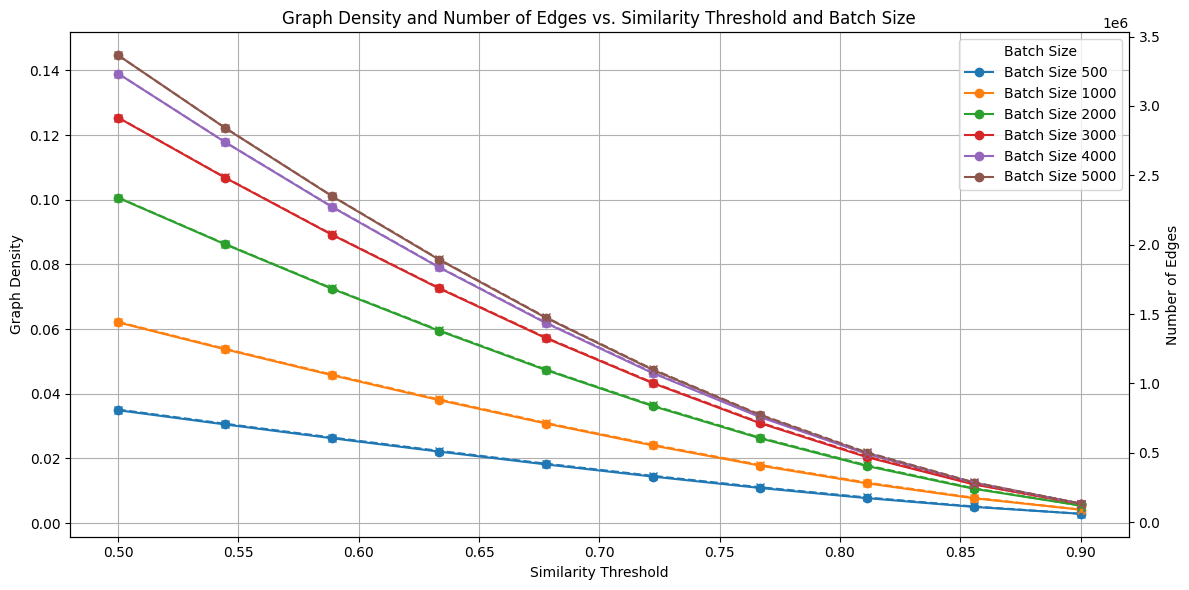

In [4]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Load the dataset from backoffice
df_pueblos = pd.read_csv("../../data/end_product_data/pueblos_recommender.csv")
pueblos_cmun = df_pueblos['cmun'].tolist()

# Filter for numerical features
df_pueblos_enc = df_pueblos.filter(regex=r"^enc_", axis=1)
pueblos_numerical_features = df_pueblos_enc.loc[:, (df_pueblos_enc.nunique() > 2)]

# Compute pairwise feature similarity (Cosine Similarity)
feature_matrix = pueblos_numerical_features
similarity_matrix = cosine_similarity(feature_matrix)

# Function to compute graph density and number of edges for a given batch size and threshold
def compute_graph_density_and_edges(batch_size, threshold):
    G = nx.Graph()
    for i in range(len(feature_matrix)):
        village_i = pueblos_cmun[i]
        for j in range(i + 1, min(i + batch_size, len(feature_matrix))):
            if similarity_matrix[i, j] > threshold:
                village_j = pueblos_cmun[j]
                G.add_edge(village_i, village_j, weight=similarity_matrix[i, j])
    return nx.density(G), G.number_of_edges()

# Range of batch sizes and thresholds to test
batch_sizes = [500, 1000, 2000, 3000, 4000, 5000]
thresholds = np.linspace(0.5, 0.9, 10)
results = []

for threshold in thresholds:
    for batch_size in batch_sizes:
        density, edges = compute_graph_density_and_edges(batch_size, threshold)
        results.append((batch_size, threshold, density, edges))

# Convert results to DataFrame for easier plotting
results_df = pd.DataFrame(results, columns=['Batch Size', 'Threshold', 'Density', 'Edges'])

# Plotting the results
fig, ax1 = plt.subplots(figsize=(12, 6))

for batch_size in batch_sizes:
    subset = results_df[results_df['Batch Size'] == batch_size]
    ax1.plot(subset['Threshold'], subset['Density'], marker='o', label=f'Batch Size {batch_size}')

ax1.set_xlabel('Similarity Threshold')
ax1.set_ylabel('Graph Density')
ax1.legend(title='Batch Size')
ax1.grid(True)

ax2 = ax1.twinx()
for batch_size in batch_sizes:
    subset = results_df[results_df['Batch Size'] == batch_size]
    ax2.plot(subset['Threshold'], subset['Edges'], marker='x', linestyle='--', label=f'Batch Size {batch_size}')

ax2.set_ylabel('Number of Edges')
plt.title('Graph Density and Number of Edges vs. Similarity Threshold and Batch Size')
fig.tight_layout()
plt.show()

## Generate the Graph based on manual optimal threshold and batch_size

In [5]:
# Add edges based on similarity threshold
threshold = 0.81  # Adjust threshold based on data distribution

# Use batching for edge creation to avoid memory issues
batch_size = 2000
for i in range(len(feature_matrix)):
    village_i = pueblos_cmun[i]
    for j in range(i + 1, min(i + batch_size, len(feature_matrix))):
        if similarity_matrix[i, j] > threshold:
            village_j = pueblos_cmun[j]
            G.add_edge(village_i, village_j, weight=similarity_matrix[i, j])



### Compute the Graph Density
Graph density tells us how connected the graph is.
A fully connected graph has density 1, while a sparse graph has density close to 0.

If density > 0.1, your graph might be too dense.
If density < 0.01, it might be too sparse.

### Calculate graph density (ratio of actual edges to potential edges in a complete graph)
 Graph density ranges from 0 (no connections) to 1 (fully connected)
- Very low density (<0.01): Too sparse, might have isolated nodes and poor recommendations
- Low density (0.01-0.05): Sparse but workable for large graphs
- Medium density (0.05-0.2): Good balance for recommendation systems
- High density (>0.2): May be too connected, less discriminative recommendations
 
If density is too high: Increase similarity threshold
If density is too low: Decrease similarity threshold or use KNN approach

In [6]:
# Calculate graph density to assess connectivity
density = nx.density(G)
print(f"Graph Density: {density:.4f}")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Check for isolated nodes
isolated = list(nx.isolates(G))
print(f"Number of isolated nodes: {len(isolated)}")

Graph Density: 0.0178
Number of nodes: 6821
Number of edges: 414563
Number of isolated nodes: 4


## Initialize the model

In [7]:
# 2️⃣ Generate Node2Vec Embeddings
node2vec = Node2Vec(G, dimensions=16, walk_length=15, num_walks=50, workers=6)

Generating walks (CPU: 6): 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


## Train the model

In [8]:
model = node2vec.fit(
    window=5,    
    min_count=1, 
    batch_words=50,  
    epochs=5,    
    sg=0,            
    hs=0,          
    negative=7        
)

## Save model and Graph

In [9]:
# Create models directory if it doesn't exist
os.makedirs('../../models', exist_ok=True)

# Save the Node2Vec embeddings
model_path = '../../models/node2vec.model'
model.save(model_path)

print(f"Model saved to {model_path}")

# If you want to save the graph separately
graph_path = '../../models/village_graph.pkl'
with open(graph_path, 'wb') as f:
    pickle.dump(G, f)
    
print(f"Graph saved to {graph_path}")

Model saved to ../../models/node2vec.model
Graph saved to ../../models/village_graph.pkl


## Why Do We Use node2vec If We Just Use Cosine Similarity Later?

Good question! Here’s why:

✅ node2vec learns embeddings that capture graph structure (community, structural similarities, etc.).
✅ These embeddings are better than raw features for similarity because they encode relationships beyond direct numerical similarity.
✅ Cosine similarity works on embeddings (not raw data), meaning it measures similarity in a meaningful latent space.

So, node2vec transforms the problem:

Instead of comparing raw village features, we compare graph-informed village embeddings using cosine similarity.

## TSVD dimensionality reduction on all centroids

In [10]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=5)

## Load the model so we don't have to train it all the time.

In [11]:
from gensim.models import Word2Vec

# Load the Node2Vec embeddings
model_path = '../../models/node2vec.model'
model = Word2Vec.load(model_path)

print(f"Model loaded from {model_path}")

# Load the graph from pickle
graph_path = '../../models/village_graph.pkl'
with open(graph_path, 'rb') as f:
    G = pickle.load(f)
    
print(f"Graph loaded from {graph_path}")

Model loaded from ../../models/node2vec.model
Graph loaded from ../../models/village_graph.pkl


In [12]:
# Ensure all CMUNs in the graph are in the DataFrame
graph_cmun_set = set(G.nodes())
df_cmun_set = set(df_pueblos['cmun'])

missing_in_df = graph_cmun_set - df_cmun_set
missing_in_graph = df_cmun_set - graph_cmun_set

print(f"CMUNs in graph but not in DataFrame: {missing_in_df}")
print(f"CMUNs in DataFrame but not in graph: {missing_in_graph}")

# Remove nodes from the graph that are not in the DataFrame
for cmun in missing_in_df:
    G.remove_node(cmun)

# Optionally, add nodes to the graph that are in the DataFrame but not in the graph
for cmun in missing_in_graph:
    G.add_node(cmun, **df_pueblos[df_pueblos['cmun'] == cmun].to_dict('records')[0])

CMUNs in graph but not in DataFrame: set()
CMUNs in DataFrame but not in graph: set()


In [14]:
# 2. Get all village vectors (handling missing nodes)
all_village_vectors = {}
for v in G.nodes():
    try:
        all_village_vectors[v] = model.wv[str(v)]
    except KeyError:
        print(f"Warning: Village {v} not found in model")
        continue

# 3. Apply TruncatedSVD to reduce dimensionality
all_vectors = np.array(list(all_village_vectors.values()))
pueblos_latent_features = svd.fit_transform(all_vectors)

In [15]:

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Get vectors for user-selected villages
user_selected_villages = user_choices_cmun
valid_villages = []
selected_vectors = []

for v in user_selected_villages:
    try:
        vector = model.wv[str(v)]
        selected_vectors.append(vector)
        valid_villages.append(v)
    except KeyError:
        print(f"Warning: Village {v} not found in model")

display(selected_vectors)
user_latent_features = svd.transform(np.array(selected_vectors))

[array([ 1.2201103 , -1.9410695 , -2.2313437 ,  5.115329  , -0.56842744,
        -0.07596323,  3.5906327 ,  2.9259913 ,  1.476347  ,  2.4186876 ,
        -1.8633956 ,  0.93672013,  3.9000843 , -3.409876  , -1.6414855 ,
        -0.8666327 ], dtype=float32),
 array([-1.4164892 , -2.0912108 ,  0.72594064,  0.51998127, -0.24853672,
        -0.18498205, -3.3468971 , -3.3721514 , -1.0364159 , -0.17207792,
        -1.5397116 ,  1.7343491 , -4.722125  ,  2.7525408 , -0.8714714 ,
         4.4957924 ], dtype=float32),
 array([-0.01700973,  0.2099975 ,  0.60053414, -0.53875566,  2.3549573 ,
        -0.02239429, -4.504432  , -1.6790806 , -0.6272427 ,  3.1523569 ,
         1.975469  ,  7.200694  ,  3.431965  ,  0.0271855 ,  0.51736724,
        -1.9780976 ], dtype=float32),
 array([-1.1170753 , -2.4515429 , -0.01355012, -4.328045  ,  2.117699  ,
         2.4881842 , -1.8101276 ,  1.4726205 , -2.396038  , -2.9851863 ,
         0.08375162,  3.1930606 ,  5.1091714 , -0.5066354 ,  2.38134   ,
         1

# Reduce selected vectors using the same transformation
## 4. Calculate similarities in reduced space

In [16]:
similarities_svd = cosine_similarity(user_latent_features, pueblos_latent_features)

df_similarities = pd.DataFrame()
df_similarities['similarity'] = similarities_svd.mean(axis=0)

df_similarities['cmun'] = G.nodes().keys()
df_similarities = df_similarities.sort_values(by='similarity', ascending=False)

df_similarities

,similarity,cmun
3552,0.685760,43011
3224,0.685299,8304
3341,0.684251,43170
3818,0.683835,43026
2540,0.682876,8084
...,...,...
4002,-0.637437,5060
4378,-0.639138,37007
3836,-0.649326,5008
3973,-0.652756,5077


## Rank the villages

NDCG Score: nan
Top 10 Most Similar Villages:
Village 43011: Similarity 0.6858
Village 8304: Similarity 0.6853
Village 43170: Similarity 0.6843
Village 43026: Similarity 0.6838
Village 8084: Similarity 0.6829
Village 17161: Similarity 0.6819
Village 8206: Similarity 0.6813
Village 8292: Similarity 0.6810
Village 43127: Similarity 0.6809
Village 8226: Similarity 0.6798

Top 10 Most Similar Villages with Names:
Village 43011 (Almoster): Similarity 0.6858
Village 8304 (Vilobí del Penedès): Similarity 0.6853
Village 43170 (Vila-rodona): Similarity 0.6843
Village 43026 (Benissanet): Similarity 0.6838
Village 8084 (Fonollosa): Similarity 0.6829
Village 17161 (Sant Feliu de Pallerols): Similarity 0.6819
Village 8206 (Sant Cugat Sesgarrigues): Similarity 0.6813
Village 8292 (Vallbona d'Anoia): Similarity 0.6810
Village 43127 (Riudecanyes): Similarity 0.6809
Village 8226 (Sant Martí de Tous): Similarity 0.6798


/var/folders/w9/bt5d4t050m7fd91t2r7l1mlh0000gn/T/ipykernel_62236/1651480735.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return dcg(ideal_scores) / dcg(sorted(ideal_scores, reverse=True))


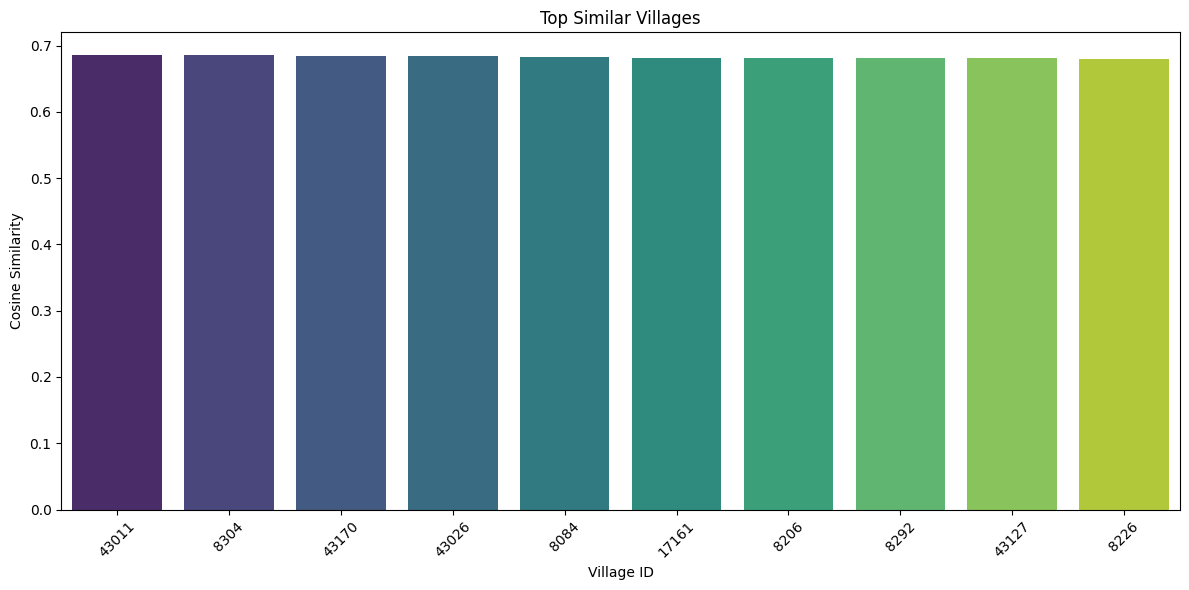

In [17]:
# Convert df_similarities to the ranked_villages format that ndcg_at_k expects
ranked_villages_from_df = list(zip(df_similarities['cmun'], df_similarities['similarity']))

# Calculate NDCG score for the recommendations
def ndcg_at_k(ranked_list, ideal_list, k):
    def dcg(scores):
        return sum([(2**s - 1) / np.log2(i+2) for i, s in enumerate(scores)])
    
    ideal_scores = [1 if v in ideal_list else 0 for v, _ in ranked_list[:k]]
    return dcg(ideal_scores) / dcg(sorted(ideal_scores, reverse=True))

# Calculate NDCG at 10
ndcg_score = ndcg_at_k(ranked_villages_from_df, user_choices_cmun, k=10)
print(f"NDCG Score: {ndcg_score:.4f}")

# Display top similar villages
print("Top 10 Most Similar Villages:")
for village, score in ranked_villages_from_df[:10]:
    print(f"Village {village}: Similarity {score:.4f}")
    
# Optional: Add village names if available
if 'municipality' in df_pueblos.columns:
    # Create a lookup dictionary for village names
    cmun_to_name = dict(zip(df_pueblos['cmun'], df_pueblos['municipality']))
    
    print("\nTop 10 Most Similar Villages with Names:")
    for village, score in ranked_villages_from_df[:10]:
        village_name = cmun_to_name.get(village, "Unknown")
        print(f"Village {village} ({village_name}): Similarity {score:.4f}")

# Visualize top similarities with a bar chart
top_n = 10
village_ids = [str(v) for v, _ in ranked_villages_from_df[:top_n]]
similarity_scores = [score for _, score in ranked_villages_from_df[:top_n]]

plt.figure(figsize=(12, 6))
sns.barplot(x=village_ids, y=similarity_scores, hue=village_ids, palette="viridis", legend=False)
plt.title('Top Similar Villages')
plt.xlabel('Village ID')
plt.ylabel('Cosine Similarity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Draws the network graph

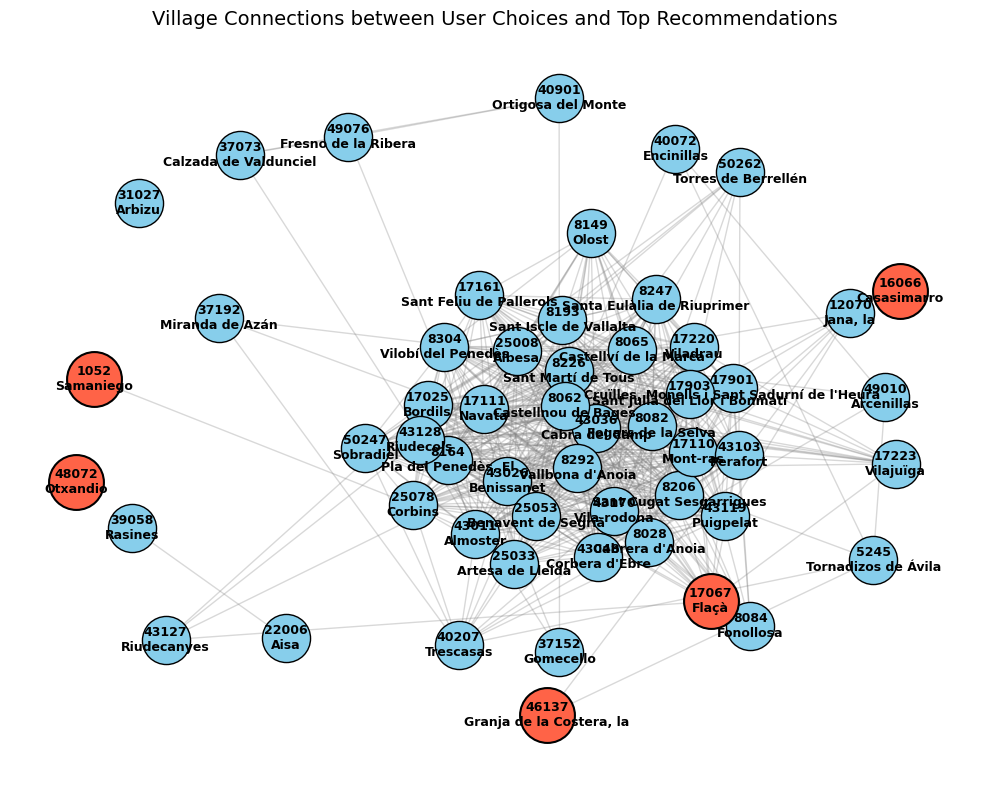

In [21]:
def plot_small_labeled_subgraph(G, nodes_to_show, figsize=(10, 8), 
                               highlight_nodes=None, title="Village Connection Subgraph",
                               with_labels=True, node_size=1200, 
                               df_pueblos=None):
    """
    Plot a small subgraph with CMUN labels visible.
    
    Parameters:
    - G: NetworkX graph
    - nodes_to_show: List of nodes to include in the visualization
    - figsize: Figure size tuple (width, height)
    - highlight_nodes: List of nodes to highlight (e.g., user selections)
    - title: Plot title
    - with_labels: Whether to show node labels
    - node_size: Size of nodes in the plot
    - df_pueblos: DataFrame with village information for name lookup
    """
    # Create subgraph of specified nodes
    H = G.subgraph(nodes_to_show)
    
    plt.figure(figsize=figsize)
    
    # Create a layout with more spacing for labels
    pos = nx.spring_layout(H, k=1.5, seed=42)  # k controls spacing
    
    # Draw edges first
    nx.draw_networkx_edges(
        H, pos,
        width=1.0,
        alpha=0.3,
        edge_color='gray'
    )
    
    # Prepare node labels
    if with_labels:
        if df_pueblos is not None:
            # Create a lookup dictionary for municipality names
            cmun_to_name = dict(zip(df_pueblos['cmun'], df_pueblos['municipality']))
            labels = {node: f"{node}\n{cmun_to_name.get(node, '')}" for node in H.nodes()}
        else:
            labels = {node: str(node) for node in H.nodes()}
    
    # Draw regular nodes
    nx.draw_networkx_nodes(
        H, pos,
        nodelist=[n for n in H.nodes() if highlight_nodes is None or n not in highlight_nodes],
        node_size=node_size,
        node_color='skyblue',
        edgecolors='black',
        linewidths=1
    )
    
    # Draw highlighted nodes if any
    if highlight_nodes:
        nx.draw_networkx_nodes(
            H, pos,
            nodelist=[n for n in H.nodes() if n in highlight_nodes],
            node_size=node_size*1.3,
            node_color='tomato',
            edgecolors='black',
            linewidths=1.5
        )
    
    # Draw labels
    if with_labels:
        nx.draw_networkx_labels(
            H, pos,
            labels=labels,
            font_size=9,
            font_weight='bold'
        )
    
    plt.title(title, fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage:
# 1. Show top recommendations and user selections
selected_nodes = user_choices_cmun
top_recommendations = [village for village, score in ranked_villages_from_df[:50]]
nodes_to_show = selected_nodes + top_recommendations

# 2. Show a small sample around a chosen node
# central_node = user_choices_cmun[0]  # First user choice
# neighbors = list(G.neighbors(central_node))
# nodes_to_show = [central_node] + neighbors[:15]  # Central node plus up to 15 neighbors

# Make the visualization
plot_small_labeled_subgraph(
    G, 
    nodes_to_show=nodes_to_show, 
    highlight_nodes=selected_nodes,
    title="Village Connections between User Choices and Top Recommendations",
    df_pueblos=df_pueblos
)